# Mobile Ad Anti-Fraud Algorithm Challenge - Data Analysis (EDA)

## 移动广告反欺诈算法挑战赛 数据分析与可视化 
-2019 科大讯飞 A.I.开发者挑战赛


-- Date:   03 Sep 2019  
-- Author:   Arianna.H

___

## Content:

- 0.Set configuration  
  
  
- 1.Explore on data  
1.1 Read data  
1.2 Shape and label distribution   
1.3 Feature description  
1.4 Identify missing value  
1.5 First glimpse of distribution of the data  
  
  
- 2.Data pre-process  
-fill missing value with existing columns/external data  
-clean punctuation/non-digit character/cases problem  
-timestamp\datatime\day\hour transformation  
-feature engineering by combining columns  
  
  
- 3.Data visualization  
-bar chart  
-line chart  
-subplotgrid  
  
  
- 4.Prepare dataset for modeling  
4.1 Correlation test for feature selection  
4.2 Label Encoding for non-numerical column  


___

## 0.Set Configuration

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  #display multiple outputs in one cell

import pandas as pd
import numpy as np
import re  #Regular Expression
from datetime import datetime  #timestamp

import scipy.stats as stats  #for chi-square
from scipy.stats import chi2_contingency  #for chi-square
import seaborn as sns  #for ANOVA
from scipy import stats  #for ANOVA
import statsmodels  #for ANOVA
import statsmodels.api as sm  #for ANOVA
from statsmodels.formula.api import ols  #for ANOVA
from sklearn.preprocessing import LabelEncoder #label encoder

pd.set_option('display.max_columns', None)  #display all columns in dataframe
pd.set_option('display.max_rows', None)  #display all columns in dataframe

____

## 1.Explore on dataset

### 1.1 Read data

In [2]:
traindata = pd.read_csv('round1_iflyad_anticheat_traindata.txt',sep = '\t',encoding = 'utf-8')
traindata.head(3)

,sid,label,pkgname,ver,adunitshowid,mediashowid,apptype,nginxtime,ip,city,province,reqrealip,adidmd5,imeimd5,idfamd5,openudidmd5,macmd5,dvctype,model,make,ntt,carrier,os,osv,orientation,lan,h,w,ppi
0,d7460126-e071-4979-9ee8-42f72777a28a-156009070...,1,2d2664e827bcbb8b07100c7fbe072e9b,11.11.0,907d0f8c29663840491577a21c7b612a,ca64a500000d84c8fcb8a0587d0e1e0c,280.0,1.560091e+12,183.197.47.83,石家庄市,-1.0,180.76.181.7,eb4fa0cf77cdd57a6993a4e42c8fa4cf,930b3a8ecff4f586c63fec5b96693f32,empty,empty,ab96caaba2b7973e63fb0d3d5c5bf8b0,2.0,V1809A,vivo,2.0,46000.0,Android,8.1.0,0.0,zh-CN,2340.0,1080.0,3.0
1,b660d559-db97-4b5f-9bd2-2450cb89ce77-156005074...,1,empty,NaN,10199dc8fea2e173525bc3151bd84312,3f2fc57a6e1f9c6fa4464c25cc1e88a3,319.0,1.560051e+12,106.34.14.149,开封市,-1.0,47.95.111.138,a4ae6efcfaee62fb6da44a9c05753259,6e38deaa1f7b4118015c550bb21913d2,empty,a4ae6efcfaee62fb6da44a9c05753259,0f607264fc6318a92b9e13c65db7cd3c,2.0,BLA-AL00,HUAWEI,5.0,0.0,android,Android_9,0.0,NaN,1080.0,2040.0,0.0
2,f49a740e-66c3-4605-9b67-4d3079fe69cb-156008914...,0,16b81f93f4b1a35cebbf15f07683f171,3.2.1.0524.1958,83f2ecfe65f936f5f2ed59f8e8ff1d01,eea7280e1a2313e4c2e89290b01d196c,273.0,1.560089e+12,223.104.16.151,长春市,-1.0,39.96.159.155,3404f799628be2cf8fda7428aac2cca4,3fa42b06332c729f530b973973fabe3d,empty,empty,5ba1cf1efeee4f83e91f9c0adc3015e3,2.0,PBEM00,OPPO,2.0,46000.0,Android,8.1.0,1.0,zh-CN,2196.0,1080.0,0.0


### 1.2 Shape and label distribution  

In [3]:
traindata.shape
# label distribution
traindata.label.value_counts(dropna=False)

(1000000, 29)

0    517106
1    482894
Name: label, dtype: int64

**Remarks:** This indicates that no label imbalance exsits in train data.

### 1.3 Features description

* **label:**  
基本数据	label	int	是否作弊 (contains 1 and 0)    
    

* **features:**  
基本数据	sid	string	样本id/请求会话sid (unique identification for each request) 
时间	nginxtime	bigint	请求到达服务时间，单位ms (definition: request processing time in seconds with a milliseconds resolution; time elapsed between the first bytes were read from the client and the log write after the last bytes were sent to the client)  
媒体信息	adunitshowid	string	对外广告位ID（MD5加密）    
媒体信息	mediashowid	string	对外媒体ID（MD5加密）       
媒体信息	pkgname	string	包名(MD5加密) 
媒体信息	apptype	int	app所属分类    
媒体信息	ver	string	app版本    
IP信息	ip	string	客户端IP地址    
IP信息	reqrealip	string	请求的http协议头携带IP，有可能是下游服务器的ip  
IP信息	city	string	城市     
IP信息	province	string	省份   
设备信息	make	string	厂商  
设备信息	model	string	机型  
设备信息	adidmd5	string	Adroid ID的MD5值  
设备信息	imeimd5	string	imei的MD5值  
设备信息	idfamd5	string	idfa的MD5值  
设备信息	openudidmd5	string	openudid的MD5值  
设备信息	macmd5	string	mac的MD5值  
设备信息	os	string	操作系统 : Android, iOS  
设备信息	osv	string	操作系统版本  
设备信息	dvctype	int	设备类型 0 – 未知,1 – PC,2 – 手机, 3– 平板,4– 电视盒,5– 智能电视,6 – 可穿戴设备,7 – 智能家电,8 - 音箱,9 - 智能硬件    
设备信息	ntt	int	网络类型 0-未知, 1-有线网, 2-WIFI, 3-蜂窝网络未知, 4-2G, 5-3G, 6–4G    
设备信息	carrier	string	运营商 0-未知, 46000-移动, 46001-联通, 46003-电信    
设备信息	lan	string	语言  
设备信息	orientation	int	横竖屏:0竖屏，1横屏   
设备信息	h	int	设备高    
设备信息	w	int	设备宽  
设备信息	ppi	int	屏幕密度  

### 1.4 Identify missing value and 'empty' values  

In [3]:
## identify the columns with missing values 
def get_missing_columns():
    missing_df = traindata.isna().sum(axis=0).to_frame()
    missing_df = missing_df.reset_index().rename(columns = {0:"missing_count"})
    missing_df = missing_df.sort_values("missing_count", ascending = False)
    missing_df = missing_df[missing_df["missing_count"] > 0]
    return missing_df

get_missing_columns()

,index,missing_count
25,lan,367527
3,ver,321824
19,make,123839
9,city,15193
23,osv,12997
18,model,4467


In [4]:
## fill missing values
def cols_to_fix():
    for c in traindata.columns:
        if traindata[c].dtype == "object":
            traindata[c] = traindata[c].fillna("nan")
        else:
            traindata[c] = traindata[c].fillna(0.0)

cols_to_fix()

### 1.5 First glimpse of distribution of the data

To analyze the dataset, we need to explore the correlation between the features and the label. Since many of the features are strings, we can check the correlation in an indiract way by looking into the distribution of label counts or label percentage of the features' unique values. 

Split train data into label_1 and label_0 to check if distributions of variables change due to diffenrent labels.  

In [6]:
label_1 = traindata.loc[traindata.label==1,:]
label_0 = traindata.loc[traindata.label==0,:]
label_1.os.value_counts(normalize=True,dropna=False).head()
label_0.os.value_counts(normalize=True,dropna=False).head()

Android    0.501831
android    0.498169
Name: os, dtype: float64

android    0.708437
Android    0.291563
Name: os, dtype: float64

Here, I clustered the features by degree of correlation between predictor variables and target variable:   
  
* **HIGH importance:**  
'ver':  large percentage(1st: 40%), large distribution difference(1st: ±30%) => HIGH importance   
'apptype':  large percentage(1st: 30%), large difference(1st: ±30%) => HIGH importance  
'dvctype':  large percentage('2'takes up 90%), large difference(1st: ±20%) => HIGH importance  
'make':  large percentage(1st: 30%), large difference(1st: ±30%) => HIGH importance  
'os':  large percentage(1st: 70%), large difference(1st & 2nd: ±20%) => HIGH importance  
'orientation':  large percentage(1st: 80%), large difference(1st & 2nd: ±20%) => HIGH importance  
'lan':  large percentage(1st: 60%), large difference(1st: ±40%) => HIGH importance  
'h':  large percentage(1st: 30%), large difference(1st: ±20%) => HIGH importance  
'pkgname': large percetage('empty'takes up 30%), large difference(2nd: ±30%) => HIGH importance    
'mediashowid': large percetage(1st: 30%), large difference(1st: ±30%) => HIGH importance    
   
   
* **MEDIUM importance:**    
'osv':  large percentage(1st: 30%), medium differences(1st & 2nd: ±10%) => MEDIUM importance  
'reqrealip':  medium percentage(1st: 10%), medium difference(1st: ±10%) => MEDIUM importance    
'adidmd5': large percetage('empty': 30%), medium difference(1st: ±10%) => MEDIUM importance    
'macmd5': large percetage('empty': 30%), medium difference(1st: ±10%) => MEDIUM importance  
'ntt':  large percetage(1st: 60%), small difference(3rd ±10%) => MEDIUM importance   
'carrier':  large percetage(1st: 70%), small difference(2nd ±7%) => MEDIUM importance   
'w': large percentage(1st: 40%),  medium difference(2nd ±20%) => MEDIUM importance  
   
   
* **LOW importance:** *(consider to increase their correlations by feature engineering)*    
'ip':  small percentage(1st: 0.3%), almost no difference(after top 5: ±0.2%) => LOW importance   
'city':  small percentage(1st: 3%), almost no difference(4th: ±2%) => LOW importance   
'province':  large percentage('-1' takes up 90%), almost no difference(after top 5: ±0.2%) => LOW importance   
'model':  small percentage(1st: 2%), small difference(2rd ±0.8%) => LOW importance   
'ppi':  large percentage(1st: 70%), almost on difference in top 5 values(after top 5: ±0.4%) => LOW importance  
'adunitshowid': small percetage(1st: 8%), small difference(unique value vary) => LOW importance     
'imeimd5': small percentage(1st: 1%) and difference(1st: ±1%) => LOW importance     
'idfamd5', 'openudidmd5': large percentage('empty'takes up 90%) with very small difference(1st: ±5%,others: ±0.01%) => LOW importance     
'nginxtime': timestamp(very sparse) => LOW importance     

___

## 2. Data pre-process

This dataset is a great example for you to practice your data cleaning skills, because it contains various forms of data, e.g. floating numbers, timestamp, strings, Chinese/English characters, alphabets in upper/lower cases, etc. Get your hands dirty ;)

#### Data Cleaning:  
For string data ['city','province' 'model', 'make', 'lan']: clean disordered characters/cases/punctuations and try to fill null values  
For timeseries data ['nginxtime']: transform it into datatime form    
For numeric data ['apptype','h','w','ppi']: clean non-digit and set null values to 0   
For ip/version data ['ip', 'reqrealip', 'ver','osv']: clean punctuations  
For id data ['pkgname', 'adunitshowid', 'mediashowid', 'adidmd5', 'imeimd5', 'idfamd5', 'openudidmd5', 'macmd5']: clean punctuations  and extact top 3 digits  


#### Feature engineering:  
['h_w','hw_ratio','inch']: use 'h','w','ppi' to calculate device size, ratio and inch  
['apptype_top1', 'apptype_top2']: extract top 1, 2 digits, convert 'apptype_top2' to int  
['osv_top1', 'osv_top2', 'osv_top3']:  extract top 1, 2, 3 digits, convert 'osv_top2', 'osv_top3' to int  
['ip_top', 'reqrealip_top']: extract top 1 string after splitting and convert them to integer  
['date','dayofweek','hour','hourtominute','hourtosecond']: extract different types of time values from datatime

#### 2.1 fill na value of 'province' with external data containing city-province information using mapping

In [5]:
# import external data
province = pd.read_csv('province_city.csv',usecols=[0,1])
province.columns = ['province', 'city']

# create dictionary for mapping
mydict = dict(zip(province.city, province.province))
traindata.province = traindata.city.map(mydict)
traindata.province = traindata.province.fillna("nan")

In [59]:
label_1 = traindata.loc[traindata.label==1,:]
label_0 = traindata.loc[traindata.label==0,:]
label_1.province.value_counts(normalize=True,dropna=False).head()
label_0.province.value_counts(normalize=True,dropna=False).head()

广东省    0.089094
江苏省    0.083905
山东省    0.066762
nan    0.056557
河南省    0.055822
Name: province, dtype: float64

广东省    0.090815
江苏省    0.073573
河南省    0.064776
浙江省    0.057977
nan    0.055428
Name: province, dtype: float64

#### 2.2 fill null values of 'make' with corresponding values in 'model' column

In [6]:
traindata.make = traindata.make.str.upper()
traindata.model = traindata.model.str.upper()
traindata.make = np.where((traindata.model.str.contains('OPPO') | 
                            traindata.model.str.contains(r'P.+[00]$',regex=True)),'OPPO',traindata.make)
traindata.make = np.where((traindata.model.str.contains('VIVO') |
                            traindata.model.str.contains(r'^V.+[A-Z]$',regex=True)),'VIVO',traindata.make)
traindata.make = np.where((traindata.model.str.contains('HUAWEI') | 
                             traindata.model.str.contains(r'-AL',regex=True) | 
                             traindata.model.str.contains(r'-TL',regex=True) |
                             traindata.make.str.contains('华为')),'HUAWEI',traindata.make)
traindata.make = np.where((traindata.make.str.contains('360手机') |
                            traindata.model.str.contains(r'^\d.+[-A].+\d$',regex=True) |
                            traindata.model.str.contains(r'^\d.+[-M].+\d$',regex=True)),'360',traindata.make)
traindata.make = np.where((traindata.make.str.contains('金立') |
                            traindata.model.str.contains('GIONEE') |
                            traindata.model.str.contains('S9')),'GIONEE',traindata.make)
traindata.make = np.where((traindata.model.str.contains('SM') |
                             traindata.make.str.contains('三星')),'SAMSUNG',traindata.make)
traindata.make = np.where((traindata.model.str.contains('MI') |
                             traindata.make.str.contains('小米')),'XIAOMI',traindata.make)
traindata.make = np.where(traindata.make.str.contains('荣耀'),'HONOR',traindata.make)
traindata.make = np.where((traindata.model.str.contains('MEIZU') | 
                            traindata.model.str.contains('16TH') |
                            traindata.model.str.contains(r'^M\d+',regex=True) |
                            traindata.make.str.contains('魅族')),'MEIZU',traindata.make)
traindata.make = np.where(traindata.make.str.contains('努比亚'),'NUBIA',traindata.make)
traindata.make = np.where((traindata.model.str.contains('COOLPAD') | 
                            traindata.make.str.contains('酷派')),'COOLPAD',traindata.make)
traindata.make = np.where((traindata.model.str.contains(r'^O.+\d$',regex=True) | 
                            traindata.make.str.contains('锤子')),'SMARTISAN',traindata.make)
traindata.make = np.where((traindata.make.str.contains('百立丰') |
                            traindata.model.str.contains('LEPHONE')),'LEPHONE',traindata.make)
traindata.make = np.where(traindata.make.str.contains('中兴'),'ZTE',traindata.make)
traindata.make = np.where(traindata.make.str.contains('联想'),'LENOVO',traindata.make)
traindata.make = np.where((traindata.make.str.contains('海信') |
                            traindata.model.str.contains('HISENSE')),'HISENSE',traindata.make)
traindata.make = np.where(traindata.model.str.contains('YU FLY F9'),'YUPLY',traindata.make) 

#### 2.3  clean 'lan' column: case, punctuation, character 

In [7]:
def get_lan(x):
    if x =="zh_":
        return "zh"
    elif x =="fr":
        return "others"
    elif x =="kr":
        return "others"
    elif x =="in_id":
        return "others"
    elif x =="mi":
        return "others"
    elif x =="zh_mo":
        return "others"
    elif x =="de":
        return "others"
    elif x =="th_th":
        return "others"
    else:
        return x

In [8]:
traindata.lan = traindata.lan.str.lower().str.replace('-','_')
traindata.lan = np.where(traindata.lan.str.contains('cn'),'zh_cn',traindata.lan)
traindata.lan = np.where(traindata.lan.str.contains('tw'),'zh_tw',traindata.lan)
traindata.lan = np.where(traindata.lan.str.contains('hk'),'zh_hk',traindata.lan)
traindata.lan = np.where(traindata.lan.str.contains('us'),'en_us',traindata.lan)
traindata.lan = traindata.lan.apply(lambda x: get_lan(x))

#### 2.4 transform 'nginxtime' from timestamp to datatime, and create different time dimensions: date, day of week, hour, minute, hourtosecond

In [9]:
traindata['nginxtime_clean'] = pd.to_datetime(traindata.nginxtime, unit='ms')
traindata['date'] = traindata.nginxtime_clean.apply(lambda x: x.day)
traindata['dayofweek'] = traindata.nginxtime_clean.apply(lambda x: x.isoweekday())
traindata['hour'] = traindata.nginxtime_clean.apply(lambda x: x.hour)
traindata['minute'] = traindata.nginxtime_clean.apply(lambda x: x.minute)
traindata['hourtosecond'] = traindata.nginxtime_clean.apply(lambda x: x.strftime('%H%M%S')).astype(int)

#### 2.5 Clean and extract first few digits of 'ip', 'reqrealip', apptype'

Suspicious ip:   
127.0.0.1 本机地址-测试 => all label1  
18.219.51.149 美国 哥伦比亚 => all label1  
192.168.(0.100) 本地局域网 => 90% label1  
10.(130.113.70) 本地局域网 => 90% label1  

This indicates that the top one or two parts before the punctuation '.' of ip can represent specific locations.

In [10]:
#'ip'
traindata['ip_top'] = np.where(traindata['ip'].str.contains(':'),'0.',traindata['ip'])
traindata['ip_top'] = traindata['ip_top'].apply(lambda x: x.split('.')[0]).astype(int)

#'reqrealip_top'
traindata['reqrealip_top'] = traindata['reqrealip'].apply(lambda x: x.split('.')[0]).astype(int)

#'apptype'
traindata['apptype_top1'] = traindata['apptype'].apply(lambda x: str(x)[0:1]).apply(lambda x: np.where(x=='-',0,x)).astype(int)
traindata['apptype_top2'] = traindata['apptype'].apply(lambda x: str(x)[0:2]).astype(int)

#### 2.6 Use h, w, ppi to create new features 'h_w' (size), 'hw_ratio', 'inch'

In [11]:
traindata['h_w'] = round((traindata.h * traindata.w),1)
traindata['hw_ratio'] = round(traindata.h / traindata.w,1)
traindata['hw_ratio'] = traindata['hw_ratio'].fillna(0.0)
traindata['inch'] = np.where(traindata.ppi==0.0, 0.0, round(np.sqrt(traindata.h**2 + traindata.w**2) / traindata.ppi,1))

#### 2.7 remove non-digit characters in  'osv', 'ver', extract top few digits

In [12]:
# remove all non-digit characters
def clean_punctuation(x):
    x = re.sub("\D", "", x)
    if x=='':
        return '0'
    else:
        return x

In [13]:
#'osv'
traindata['osv_clean'] = traindata['osv'].astype(str).apply(lambda x: clean_punctuation(x))
traindata['osv_top1'] = traindata['osv_clean'].apply(lambda x: x[0:1]).astype(int)
traindata['osv_top2'] = traindata['osv_clean'].apply(lambda x: x[0:2]).astype(int)
traindata['osv_top3'] = traindata['osv_clean'].apply(lambda x: x[0:3]).astype(int)

#'ver' 
traindata['ver_clean'] = traindata['ver'].apply(lambda x: clean_punctuation(x))
traindata['ver_top1'] = traindata['ver_clean'].apply(lambda x: x[0:1]).astype(int)
traindata['ver_top2'] = traindata['ver_clean'].apply(lambda x: x[0:2]).astype(int)
traindata['ver_top3'] = traindata['ver_clean'].apply(lambda x: x[0:3]).astype(int)

#### 2.8 remove alphabets in 'id' like columns, extract top 3 digits

* The columns that contain 'Empty' values:   
pkgname    263239  
adunitshowid    296  
mediashowid    296  
adidmd5    254158  
imeimd5    6868  
idfamd5    999641  
openudidmd5    918400  
macmd5    418236  

In [17]:
# id_column = ['pkgname','adunitshowid','mediashowid','adidmd5','imeimd5','openudidmd5','macmd5']
# for i in id_column:
#     traindata[i] = traindata[i].apply(lambda x: clean_punctuation(x)).apply(lambda x: x[0:3]).astype(int)

___

## 3. Data Visualization
have fun with plotting:D

In [18]:
label_1 = traindata.loc[traindata.label==1,:]
label_0 = traindata.loc[traindata.label==0,:]

#### make : Plot make distribution

In [19]:
import matplotlib.pyplot as plt  #plot

# '_ =' to ignore unwanted output
fig = plt.figure()
_ = fig.set(alpha=0.5)
fig.set_size_inches(12,3)
_ = plt.subplot2grid((1,2),(0,0))
_ = label_1.make.value_counts().head(10).plot.bar(width=0.4, color='xkcd:lightblue')
_ = plt.title(u"make_label_1")
_ = plt.subplot2grid((1,2),(0,1))
_ = label_0.make.value_counts().head(10).plot.bar(width=0.4, color='xkcd:lavender')
_ = plt.title(u"make_label_0")

#### lan : Plot language distribution

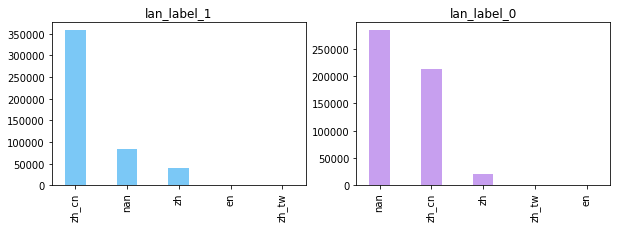

In [20]:
fig = plt.figure()
_ = fig.set(alpha=0.5)
fig.set_size_inches(10,3)
_ = plt.subplot2grid((1,2),(0,0))
_ = label_1.lan.value_counts().head().plot.bar(width=0.4, color='xkcd:lightblue')
_ = plt.title(u"lan_label_1")
_ = plt.subplot2grid((1,2),(0,1))
_ = label_0.lan.value_counts().head().plot.bar(width=0.4, color='xkcd:lavender')
_ = plt.title(u"lan_label_0")

#### nginxtime : Plot label distribution per day of a week and per hour

In [21]:
dayofweek_df = pd.DataFrame(columns = ['dayofweek','label_1', 'label_0', 'label_all', 'label_1_%','label_0_%'])
dayofweek_df['dayofweek'] = traindata.dayofweek.sort_values().unique()
dayofweek_df['label_1'] = traindata[traindata['label']==1].dayofweek.value_counts().sort_index().tolist()
dayofweek_df['label_0'] = traindata[traindata['label']==0].dayofweek.value_counts().sort_index().tolist()
dayofweek_df['label_all'] = dayofweek_df['label_1']+dayofweek_df['label_0']
dayofweek_df['label_1_%'] = dayofweek_df['label_1']/dayofweek_df['label_all']
dayofweek_df['label_0_%'] = dayofweek_df['label_0']/dayofweek_df['label_all']

In [22]:
hour_df = pd.DataFrame(columns = ['hour','label_1', 'label_0', 'label_all', 'label_1_%','label_0_%'])
hour_df['hour'] = traindata.hour.sort_values().unique()
hour_df['label_1'] = traindata.loc[traindata['label']==1].hour.value_counts().sort_index().tolist()
hour_df['label_0'] = traindata.loc[traindata['label']==0].hour.value_counts().sort_index().tolist()
hour_df['label_all'] = hour_df['label_1']+hour_df['label_0']
hour_df['label_1_%'] = hour_df['label_1']/hour_df['label_all']
hour_df['label_0_%'] = hour_df['label_0']/hour_df['label_all']

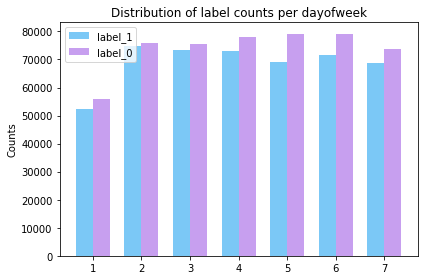

In [23]:
x = np.arange(len(dayofweek_df['dayofweek']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(6,4)
_ = rects1 = ax.bar(x - width/2, dayofweek_df['label_1'], width, label='label_1', color='xkcd:lightblue')
_ = rects2 = ax.bar(x + width/2, dayofweek_df['label_0'], width, label='label_0', color='xkcd:lavender')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = ax.set_ylabel('Counts')
_ = ax.set_title('Distribution of label counts per dayofweek')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(dayofweek_df['dayofweek'])
_ = ax.legend()

fig.tight_layout()
plt.show()

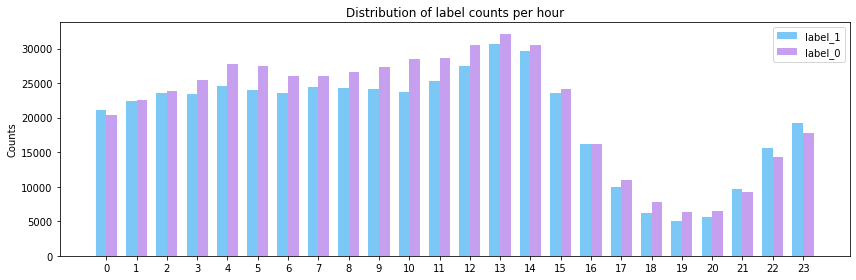

In [24]:
x = np.arange(len(hour_df['hour']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(12,4)
_ = rects1 = ax.bar(x - width/2, hour_df['label_1'], width, label='label_1', color='xkcd:lightblue')
_ = rects2 = ax.bar(x + width/2, hour_df['label_0'], width, label='label_0', color='xkcd:lavender')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = ax.set_ylabel('Counts')
_ = ax.set_title('Distribution of label counts per hour')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(hour_df['hour'])
_ = ax.legend()

fig.tight_layout()
plt.show()

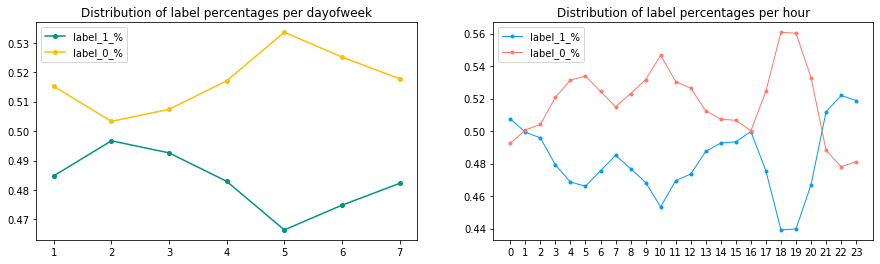

In [25]:
fig = plt.figure()
_ = fig.set(alpha=0.5)
fig.set_size_inches(15,4)

_ = plt.subplot2grid((1,2),(0,0))
_ = plt.plot( 'dayofweek', 'label_1_%', data=dayofweek_df, marker='o', markerfacecolor='xkcd:teal', markersize=4, color='xkcd:teal', linewidth=1.5)
_ = plt.plot( 'dayofweek', 'label_0_%', data=dayofweek_df, marker='o', markerfacecolor='xkcd:goldenrod', markersize=4, color='xkcd:goldenrod', linewidth=1.5)
_ = plt.legend()
_ = plt.title(u"Distribution of label percentages per dayofweek")

_ = plt.subplot2grid((1,2),(0,1))
_ = plt.plot( 'hour', 'label_1_%', data=hour_df, marker='o', markerfacecolor='xkcd:azure', markersize=3, color='xkcd:azure', linewidth=1)
_ = plt.plot( 'hour', 'label_0_%', data=hour_df, marker='o', markerfacecolor='xkcd:salmon', markersize=3, color='xkcd:salmon', linewidth=1)
_ = plt.legend()
_ = plt.xticks(np.arange(len(hour_df['hour'])))
_ = plt.title(u"Distribution of label percentages per hour")

plt.show()

**Remarks:**

The graphs are more intuitive to show the relationships. We can see obviously that there are several features contributing to label 0(if we assume that label 0 refers to fraud)

The first two pictures show that fraud behaviour concentrates in OPPO and VIVO, meaning that phones made by these two manufactures are more easily to be made use of in terms of faking ip or others.

The second two bar charts show that the suspicious behaviour usually coincides with not defined language, says 'nan', and in general the normal behaviour will display 'chinese' as the language.  

Other graphs indicate that the probability of ad fraud changes with hour and day of a week.

___

## 4. Prepare Dataset for modeling
### 4.1 Correlation significant test  for feature selection  

- #### Chi Square Analysis   

Simple correlation test using DateFrame.corr() can only be used in tesing between continuous variables. Given that our label is nominal and so are many independent variables, we use Chi Square analysis to test the correlation between them: According to the P value results, 'sid' and 'idfamd5' are uncorrelated features which should be discarded.

In [74]:
## Feature Selection    
# traindata.columns
# traindata.dtypes == 'object'

nominalColumns = [ 'sid', 'pkgname', 'ver', 'adunitshowid', 'mediashowid',
       'apptype', 'ip', 'city', 'province', 'reqrealip',
       'adidmd5', 'imeimd5', 'idfamd5', 'openudidmd5', 'macmd5', 'dvctype',
       'model', 'make', 'ntt', 'carrier', 'os', 'osv', 'orientation', 'lan',
       'date', 'dayofweek', 'hour',
       'minute', 'hourtosecond', 'ip_top', 'reqrealip_top', 'apptype_top1',
       'apptype_top2', 'osv_clean', 'osv_top1',
       'osv_top2', 'osv_top3', 'ver_clean', 'ver_top1', 'ver_top2',
       'ver_top3']

In [76]:
## Introduce ChiSquare Class     

print('Staring testing...')
class ChiSquare:
    def __init__(self, dataframe):
        
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None  #Chi Test Statistic
        self.dof = None
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{} - IMPORTANT predictor. Chi-Statistic: {:.2f}, P-value: {:.4f}".format(colX,self.chi2,self.p) 
        else:
            result="{} - NOT important predictor. Chi-Statistic: {:.2f}, P-value: {:.4f}  ==>  Discard".format(colX,self.chi2,self.p)

        print(result)
        
    def TestIndependence(self, colX, colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved =  pd.crosstab(Y,X)
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        self._print_chisquare_result(colX,alpha)
        
        
## Initialize ChiSquare Class   
   
cT = ChiSquare(traindata)

for var in nominalColumns:
    cT.TestIndependence(colX=var, colY='label')

Staring testing...
sid - NOT important predictor. Chi-Statistic: 1000000.00, P-value: 0.4995  ==>  Discard
pkgname - IMPORTANT predictor. Chi-Statistic: 407817.87, P-value: 0.0000
ver - IMPORTANT predictor. Chi-Statistic: 395837.76, P-value: 0.0000
adunitshowid - IMPORTANT predictor. Chi-Statistic: 552043.97, P-value: 0.0000
mediashowid - IMPORTANT predictor. Chi-Statistic: 500428.72, P-value: 0.0000
apptype - IMPORTANT predictor. Chi-Statistic: 362222.62, P-value: 0.0000
ip - IMPORTANT predictor. Chi-Statistic: 787269.08, P-value: 0.0000
city - IMPORTANT predictor. Chi-Statistic: 16142.63, P-value: 0.0000
province - IMPORTANT predictor. Chi-Statistic: 8908.61, P-value: 0.0000
reqrealip - IMPORTANT predictor. Chi-Statistic: 451010.96, P-value: 0.0000
adidmd5 - IMPORTANT predictor. Chi-Statistic: 754220.07, P-value: 0.0000
imeimd5 - IMPORTANT predictor. Chi-Statistic: 996880.35, P-value: 0.0000
idfamd5 - NOT important predictor. Chi-Statistic: 369.80, P-value: 0.3224  ==>  Discard
openu

- #### ANOVA Analysis  

ANOVA cannot prove causation. It can tell us whether the mean value of independent variables of each label group are different at a statistically significant level. In this case taking 'h' for an example, our null hypothesis is that all group mean height are the same.

We start by visualizing the impact of each label on the height variable with a box plot usinf Seaborn data visualization package. Figure 1 tells us that label 0 seems to have more zero than label 1 and have larger standard deviations; The mean height of each lable is similar. 

Analysis of Variance or ANOVA tells us whether the differences in the variance between each label group are statistically significant when compared to the differences within each group.

One of the core assumptions with ANOVA is that the dependent variable is normally distributed.   
However, the distribution of h is not normal, so ANOVA is not appropriate to use in this situation.

In [77]:
## Feature Selection    
continuousColumns = ['h', 'w', 'ppi', 'h_w', 'hw_ratio', 'inch']

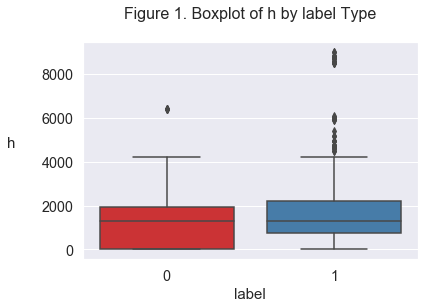

In [106]:
sns.set(font_scale=1.3)  #sets font size for chart scales
ax = sns.boxplot(x = "label", y = "h", data = traindata, # calls the boxplot
                 palette="Set1", # sets color scheme 
                 linewidth = 1.5) # sets chart line width
_ = ax.set_title("Figure 1. Boxplot of h by label Type\n", fontsize=16) # title 
_ = ax.set_ylabel("h", rotation = 0, fontsize=15, labelpad=30) # y-axis label
_ = ax.set_xlabel("label", rotation = 0, fontsize=15) # x-axis label
plt.show()

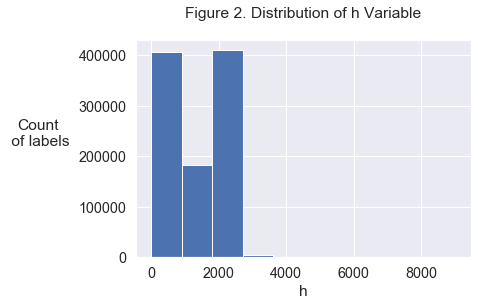

In [107]:
_ = plt.hist(traindata['h']) # check for variable normality in h dependent variable. 
#Data looks not normally distributed.
_ = plt.title("Figure 2. Distribution of h Variable\n")
_ = plt.xlabel("h")
_ = plt.ylabel("Count\n of labels", rotation = 0, labelpad = 40)
plt.show()

In [108]:
# check p-score of normal distribution
print(stats.normaltest(traindata['h'], axis=0))

NormaltestResult(statistic=1373260.835350655, pvalue=0.0)


Now we create an Ordinary Least Squares (OLS) model as a precursor to the ANOVA.   

Before the ANOVA, we check the OLS residuals are normally distributed. This is another important prior assumption:    
The residuals look not normal at all. Thus, we cannot run ANOVA here.  

Text(0.5, 1.0, 'Figure 3. Distribution of OLS Model Residuals')

Text(0.5, 0, 'Residual Values')

Text(0, 0.5, 'Count')

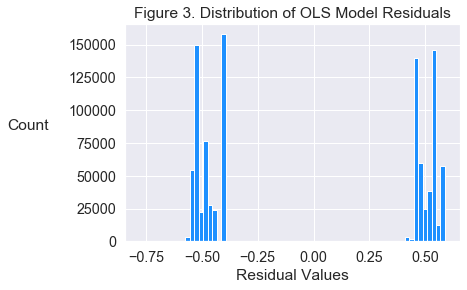

In [109]:
anova_mod = ols("label ~ h", traindata).fit()
resids = statsmodels.regression.linear_model.RegressionResults.resid(anova_mod) # grabs the residual values from the OLS model
hist2 = plt.hist(resids, bins = 'auto', color='dodgerblue') # check for variable normality in weight loss dependent variable. 
#Data looks not normally distributed.
_ = plt.title("Figure 3. Distribution of OLS Model Residuals")
_ = plt.xlabel("Residual Values")
_ = plt.ylabel("Count", rotation = 0, labelpad = 40)
plt.show()

In [ ]:
# Call for ANOVA function if residuals are normally distributed.

table = sm.stats.anova_lm(model, typ=2) # Type 2 ANOVA DataFrame
print(table) 

# In a one-way ANOVA the null hypothesis is that the means of the Diet types are equal. We can reject that hypothesis
# because P < 0.05 

### 4.2 Label Encoding for non-numerical columns

In [14]:
traindata.columns

Index(['sid', 'label', 'pkgname', 'ver', 'adunitshowid', 'mediashowid',
       'apptype', 'nginxtime', 'ip', 'city', 'province', 'reqrealip',
       'adidmd5', 'imeimd5', 'idfamd5', 'openudidmd5', 'macmd5', 'dvctype',
       'model', 'make', 'ntt', 'carrier', 'os', 'osv', 'orientation', 'lan',
       'h', 'w', 'ppi', 'nginxtime_clean', 'date', 'dayofweek', 'hour',
       'minute', 'hourtosecond', 'ip_top', 'reqrealip_top', 'apptype_top1',
       'apptype_top2', 'h_w', 'hw_ratio', 'inch', 'osv_clean', 'osv_top1',
       'osv_top2', 'osv_top3', 'ver_clean', 'ver_top1', 'ver_top2',
       'ver_top3'],
      dtype='object')

In [15]:
traindata_1 = traindata.loc[:,['label', 'pkgname', 'ver', 'adunitshowid', 'mediashowid',
       'apptype', 'ip', 'city', 'province', 'reqrealip',
       'adidmd5', 'imeimd5',  'openudidmd5', 'macmd5', 'dvctype',
       'model', 'make', 'ntt', 'carrier', 'os', 'osv', 'orientation', 'lan',
       'h', 'w', 'ppi', 'date', 'dayofweek', 'hour', 'minute', 'hourtosecond', 
       'ip_top', 'reqrealip_top', 'apptype_top1', 'apptype_top2', 
       'h_w', 'hw_ratio', 'inch', 'osv_clean',  'osv_top1', 'osv_top2', 'osv_top3',
       'ver_clean', 'ver_top1', 'ver_top2', 'ver_top3']]

In [17]:
## Transform non-numerical data to numerical labels (0 to n_classes-1)
le = LabelEncoder()
for col in traindata_1.columns:
    if traindata_1[col].dtype == "object":
        traindata_1[col] = le.fit_transform(traindata_1[col])

Check new dataset with all numeric data:

In [18]:
traindata.shape
traindata_1.shape
traindata_1.head(3)

(1000000, 50)

(1000000, 46)

,label,pkgname,ver,adunitshowid,mediashowid,apptype,ip,city,province,reqrealip,adidmd5,imeimd5,openudidmd5,macmd5,dvctype,model,make,ntt,carrier,os,osv,orientation,lan,h,w,ppi,date,dayofweek,hour,minute,hourtosecond,ip_top,reqrealip_top,apptype_top1,apptype_top2,h_w,hw_ratio,inch,osv_clean,osv_top1,osv_top2,osv_top3,ver_clean,ver_top1,ver_top2,ver_top3
0,1,402,174,452,239,280.0,475455,229,17,5102,652267,535931,73758,199768,2.0,6202,816,2.0,46000.0,0,136,0.0,9,2340.0,1080.0,3.0,9,7,14,31,143141,183,180,2,28,2527200.0,2.2,859.1,138,8,81,810,74,1,11,111
1,1,2174,3180,45,61,319.0,41248,119,18,8127,456711,402019,50767,18010,2.0,602,332,5.0,0.0,1,175,0.0,6,1080.0,2040.0,0.0,9,7,3,25,32540,106,47,3,31,2203200.0,0.5,0.0,140,9,9,9,0,0,0,0
2,0,230,626,422,282,273.0,563455,296,5,7875,144447,232089,73758,106563,2.0,4816,572,2.0,46000.0,0,136,1.0,9,2196.0,1080.0,0.0,9,7,14,5,140545,223,39,2,27,2371680.0,2.0,0.0,138,8,81,810,1188,3,32,321


In [19]:
traindata_1.to_csv('round1_iflyad_anticheat_train_clean.csv', index=False)

In [ ]:
# delete idle dataframe to save memory
#del traindata

---  End of EDA part  ---

_____